In [36]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
locale.getpreferredencoding()

'UTF-8'

In [1]:
!pip install clip-retrieval
!pip install -qq diffusers["torch"] transformers datasets
!pip install -qq "ipywidgets>=7,<8"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.4/343.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.5/139.5 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 18.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autofaiss 2.15.8 requires pyarrow<13,>=6.0.1,

# Image Captioning

In [2]:
import torch
import requests
import os
import shutil
from tqdm import tqdm
import json
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
import pyarrow.parquet as pq

In [3]:
catalog_path = "/content/catalog"
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base", torch_dtype=torch.float16).to("cuda")

In [4]:
def get_caption(img_path):
  raw_image = Image.open(img_path).convert('RGB')
  inputs = processor(raw_image, return_tensors="pt").to("cuda", torch.float16)
  out = model.generate(**inputs)
  return processor.decode(out[0], skip_special_tokens=True)

In [10]:
images = os.listdir(catalog_path)
images = [img for img in images if img.endswith(".png") or img.endswith(".jpg")]

for img in tqdm(images):
  img_path = os.path.join(catalog_path, img)
  img_caption = get_caption(img_path)
  caption_file = os.path.join(catalog_path, img.split(".")[0]+".txt")
  with open(caption_file, "w+") as f:
    f.write(img_caption)

  0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


# Clip retrieval

In [11]:
from clip_retrieval import clip_inference
from clip_retrieval import clip_index
from clip_retrieval.clip_back import clip_back, load_clip_indices, ClipOptions
from knn_service import KnnServer

In [12]:
embeddings_path = "embeddings"
index_path, indice_path = "index", "index.json"

In [13]:
if os.path.exists(embeddings_path):
    shutil.rmtree(embeddings_path)

clip_inference(
    input_dataset=catalog_path,
    output_folder=embeddings_path,
    input_format="files",
    enable_metadata=True,
    write_batch_size=16,
    batch_size=16,
    cache_path=None,
    num_prepro_workers=0
)

The number of samples has been estimated to be 9
Starting the worker
dataset is 16
Starting work on task 0


100%|████████████████████████████████████████| 354M/354M [00:03<00:00, 100MiB/s]


warming up with batch size 16 on cuda
done warming up in 0.3197493553161621s


In [14]:
if os.path.exists(index_path):
    shutil.rmtree(index_path)

if not os.path.isdir(index_path):
  clip_index(embeddings_path, index_folder=index_path)

if not os.path.isfile(indice_path):
  indice_dict = {"example_index": index_path}
  with open(indice_path, "w+") as js:
      json.dump(indice_dict, js)

  0%|          | 0/1 [00:00<?, ?it/s]


In [15]:
columns_to_return = ["image_path", "caption", "id", "similarity"]
clip_resources = load_clip_indices(
    indices_paths=indice_path,
    clip_options=ClipOptions(
        indice_folder=index_path,
        clip_model="ViT-B/32",
        enable_hdf5=False,
        enable_faiss_memory_mapping=False,
        columns_to_return=columns_to_return,
        reorder_metadata_by_ivf_index=False,
        enable_mclip_option=False,
        use_jit=True,
        use_arrow=False,
        provide_safety_model=False,
        provide_violence_detector=False,
        provide_aesthetic_embeddings=True,
    ),
)
knn_service = KnnServer(clip_resources)
print("Indices loaded for KNN service")

warming up with batch size 1 on cuda


/usr/local/lib/python3.10/dist-packages/clip/clip.py:160: FutureWarning: 'torch.onnx._patch_torch._node_getitem' is deprecated in version 1.13 and will be removed in version 1.14. Please Internally use '_node_get' in symbolic_helper instead..
  if "value" in node.attributeNames() and str(node["value"]).startswith("cuda"):


done warming up in 5.274389982223511s
Indices loaded for KNN service


In [16]:
def query_search(text):
      return knn_service.query(text_input=text)

In [17]:
text_query = "black crewneck crop top"
knn_img_path = query_search(text_query)[0]["image_path"]
knn_img_path

'/content/catalog/img2.png'

# Text guided Image to Image generation

In [23]:
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInstructPix2PixPipeline
import numpy as np
import matplotlib.pyplot as plt

In [19]:
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    "timbrooks/instruct-pix2pix", torch_dtype=torch.float16
)
pipe = pipe.to("cuda")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [ ]:
def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")

  0%|          | 0/100 [00:00<?, ?it/s]

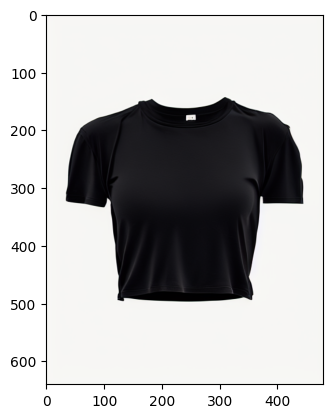

In [25]:
image = PIL.Image.open(knn_img_path).convert("RGB")
prompt = "black short sleeve crop top"
image = pipe(prompt=prompt, image=image).images[0]
image.save("black_short_sleeve_crop_top.png")
img = np.array(image).astype(np.uint8)
plt.imshow(img)

# Clothes segmentation

In [26]:
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
import cv2
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch.nn as nn

seg_processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
seg_model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


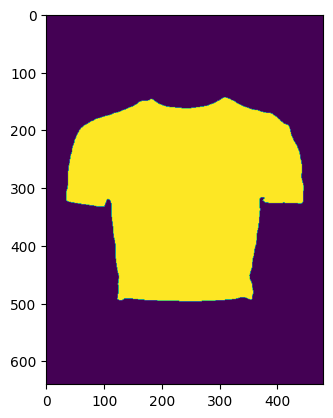

In [27]:
inputs = seg_processor(images=image, return_tensors="pt")
outputs = seg_model(**inputs)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]
pred_seg = pred_seg.numpy()
plt.imshow(pred_seg)

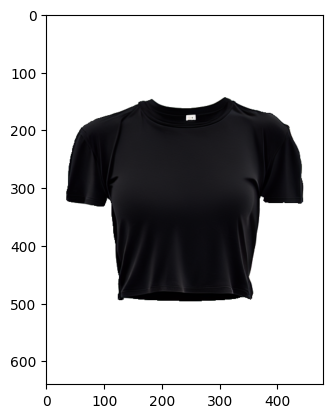

In [28]:
mask = np.equal(pred_seg, 4).astype(np.uint8)
if not np.sum(mask):
  mask = np.equal(pred_seg, 7).astype(np.uint8)
mask = cv2.GaussianBlur(mask,(7,7),0)
mask = cv2.threshold(mask, 5, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
kernel = np.ones((7, 7), np.uint8)
closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
mask = cv2.threshold(mask, 5, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
mask = mask//255
fgnd_mask=(mask==1)
result = np.ones_like(img).astype(np.uint8)*255
result[fgnd_mask] = img[fgnd_mask]
Image.fromarray(result).save(f"result_img_out.png")
plt.imshow(result)

# Fashion Stable Diffusion

In [29]:
from diffusers import StableDiffusionPipeline
import torch

pipeline = StableDiffusionPipeline.from_pretrained("MohamedRashad/diffusion_fashion", torch_dtype=torch.float16).to("cuda")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.21.1",
  "_name_or_path": "MohamedRashad/diffusion_fashion",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/50 [00:00<?, ?it/s]

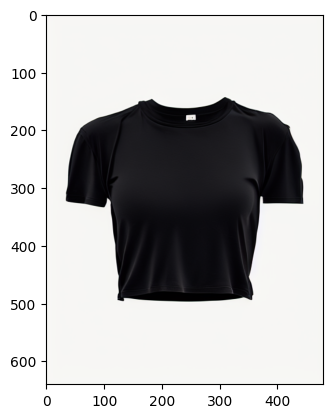

In [34]:
prompt = "A photo of a short sleeve crewneck crop top, color is black, Casual usage, Women's cloth, something for the summer season, on white background"
images = pipeline(prompt).images[0]
image.save("black_croptop.png")
img = np.array(image).astype(np.uint8)
plt.imshow(img)

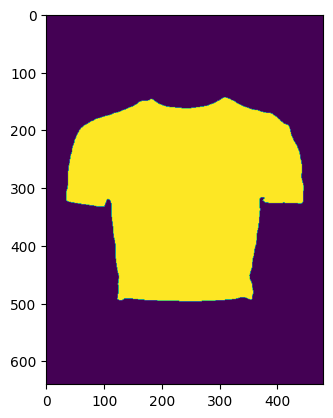

In [32]:
inputs = seg_processor(images=image, return_tensors="pt")
outputs = seg_model(**inputs)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]
pred_seg = pred_seg.numpy()
plt.imshow(pred_seg)

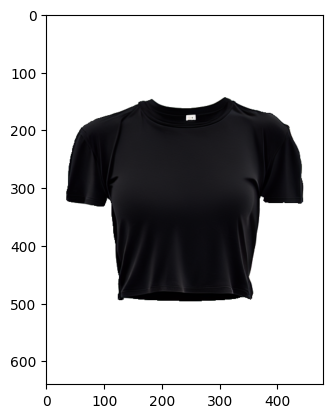

In [33]:
mask = np.equal(pred_seg, 4).astype(np.uint8)
if not np.sum(mask):
  mask = np.equal(pred_seg, 7).astype(np.uint8)
mask = cv2.GaussianBlur(mask,(7,7),0)
mask = cv2.threshold(mask, 5, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
kernel = np.ones((7, 7), np.uint8)
closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
mask = cv2.threshold(mask, 5, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
mask = mask//255
fgnd_mask=(mask==1)
result = np.ones_like(img).astype(np.uint8)*255
result[fgnd_mask] = img[fgnd_mask]
Image.fromarray(result).save(f"result_img_out.png")
plt.imshow(result)